# The SVHN dataset (32-by-32 images)

#### Preprocessing of the 32 by 32 images from the SVHN dataset

---

The following notebook contains my code for loading, examining and pre-processing the 32-by-32 images from the SVHN dataset centered around a single digit. In this dataset all digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions

In this notebook we apply the following preprocessing steps:

* Create a balanced validation set
* Change the label values of 0's from 10 to 0
* RGB to grayscale convertion

In [20]:
for i in range(0, 100000, 10000):
    decayed_learning_rate = 0.075 * 0.95 ** (i / 10000)
    print("%.3f" % decayed_learning_rate)

0.075
0.071
0.068
0.064
0.061
0.058
0.055
0.052
0.050
0.047


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

## Loading the Data

The dataset comes in the MAT-File Format and we can use [``scipy.io.loadmat``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) to load the dataset.

In [2]:
from scipy.io import loadmat

def load_data(path):
    """ Helper function for loading a MAT-File """
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('data/train_32x32.mat')
X_test, y_test = load_data('data/test_32x32.mat')
X_extra, y_extra = load_data('data/extra_32x32.mat')

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

('Training', (32, 32, 3, 73257), (73257, 1))
('Test', (32, 32, 3, 26032), (26032, 1))
('Extra', (32, 32, 3, 531131), (531131, 1))


Let's permute the dimensions of the array to get the data into a more manageable format where the indexes correspond to (``image idx, row, column and color channel``).

In [3]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
X_extra, y_extra = X_extra.transpose((3,0,1,2)), y_extra[:,0]

print("Training", X_train.shape)
print("Test", X_test.shape)
print("Extra", X_extra.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0] + X_extra.shape[0]

print("Total Number of Images", num_images)

('Training', (73257, 32, 32, 3))
('Test', (26032, 32, 32, 3))
('Extra', (531131, 32, 32, 3))

('Total Number of Images', 630420)


Let's render some images. In Matplotlib this is done using ``imshow()``. Here i have written a simple helper function that dynamically sets the ``width``and the ``height`` of figure and renders a grid consiting of ``nrows`` * ``ncols`` images.

In [4]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

Let's render a set of digits from the ``training set``, ``test set`` and ``validation set``.

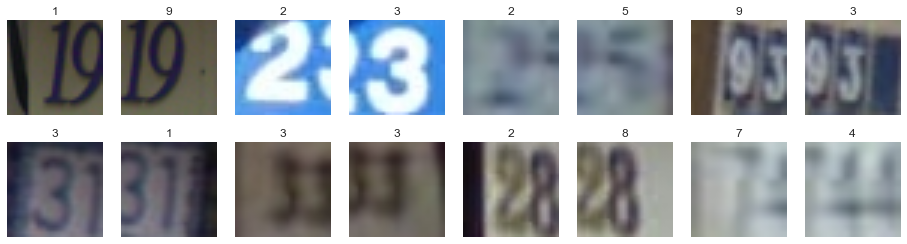

In [5]:
# Plot some training set images
plot_images(X_train, y_train, 2, 8)

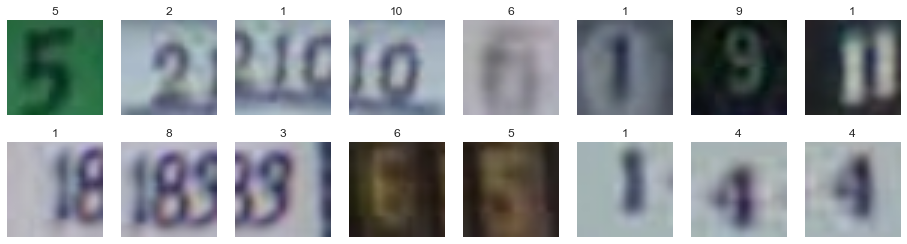

In [6]:
# Plot some test set images
plot_images(X_test, y_test, 2, 8)

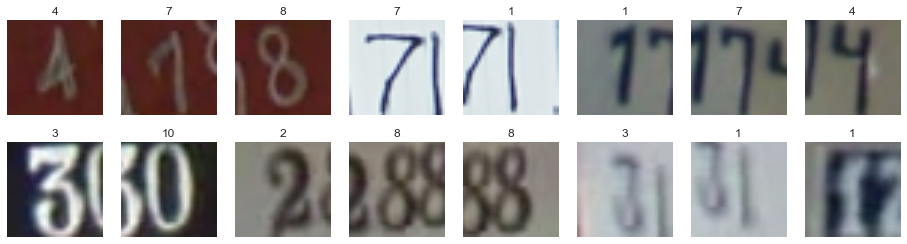

In [7]:
# Plot some extra set images
plot_images(X_extra, y_extra, 2, 8)

Zeros have been labeled as 10 in this dataset. To verify this we can  contained in the labels array using ``numpy.unique()``

In [8]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


Let's check the class balance in our dataset by plotting a histogram showing the value distributions.

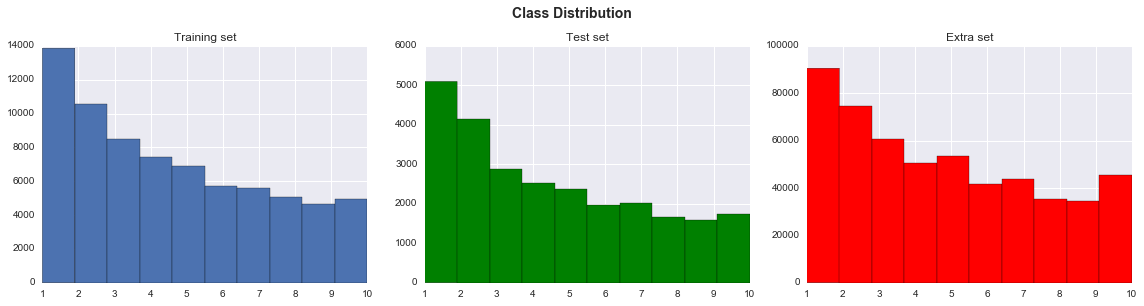

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

ax3.hist(y_extra, color='r', bins=10);
ax3.set_title("Extra set");

fig.tight_layout()

All distributions have a positiv skew, meaning that we have an overweight of smaller values.

## Preprocessing

After skimming some of the publications with the lowest error rate on the SVHN dataset, found [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e) i found the following written on pre-processing techniques applied to the SVHN dataset.

* [Chang et al. 2015](https://arxiv.org/abs/1511.02583) and [Lee et al. 2014](http://vcl.ucsd.edu/~sxie/2014/09/12/dsn-project/) both report creating a balanced validation set
* [Liang et al. 2015](http://www.cv-foundation.org/openaccess/content_cvpr_2015/app/2B_004.pdf) report that the pre-processed the images by removing the per-pixel mean value calculated over the the entire set.
* [Lee et al. 2014](http://jmlr.org/proceedings/papers/v38/lee15a.pdf) and [Goodfellow et al. 2014](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf) report using [local contrast normalization](http://scikit-image.org/docs/dev/auto_examples/plot_local_equalize.html) to preprocess the images.
* [Goodfellow et al. 2013](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf) report that they subtract the mean from every image.

Normalization refers to normalizing the data dimensions so that they are of approximately the same scale. There are two common ways of achieving this normalization. One is to divide each dimension by its standard deviation, once it has been zero-centered. Another form of this preprocessing normalizes each dimension so that the min and max along the dimension is -1 and 1 respectively. The following figure taken from the [CS231n notes](http://cs231n.github.io/neural-networks-2/) illutrates how this changes the data.

<img style="float:left; width:75%" src="http://cs231n.github.io/assets/nn2/prepro1.jpeg"/>

<br clear="all"/>

Because the motivation behind this experiment is knowledge and not a highly optimized solution we will replicate the validation set approach described above to be able to compare our results against a benchmark and convert the images to grayscale to reduce the total amount of data we have to preprocess. If any additional pre-processing is required it can be applied before feeding the data to the model.

**Preprocessing Steps:**

1. Update the label value of zero images to 0
2. Created a balanced validation set with with an equal number of exampels from each class with a combination of easy and hard samples
3. Convert images from RGB to grayscale

### Update label of zero images to 0

Let's start by applying a quick fix. Set the zero labes to 0 as we'll use the value 10 for empty digits when learning to recognize sequences of digits.

In [10]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
y_extra[y_extra == 10] = 0

### Creating a Balanced Validation Set

The dataset is divided into three subsets: train set, extra set and test set. The extra set is a large set of easy samples and train set is a smaller set of more difficult samples. Since we are given no information about how the sampling of these images was done, we assume a random order to construct our validation set. We compose our validation set with 2/3 from training samples (400 per class) and 1/3 from extra samples (200 per class), yielding a total of 6000 samples.

We want to have a balanced validation set consisting of both easy examples from the validation set and some hard ones from the training set. The sample contains ``s`` images of each class.

In [11]:
def balanced_subsample(y, s):
    """Return a balanced subsample of the population"""
    sample = []
    # For every label in the dataset
    for label in np.unique(y):
        # Get the index of all images with a specific label
        images = np.where(y==label)[0]
        # Draw a random sample from the images
        random_sample = np.random.choice(images, size=s, replace=False)
        # Add the random sample to our subsample list
        sample += random_sample.tolist()
    return sample

Create a validation set by selecting a balanced subsample of 400 images of each class from the training set and 200 images of each class from the extra set. This gives us a total of 6000 images in our validation set.

In [12]:
# Pick 400 samples per class from the training samples
train_samples = balanced_subsample(y_train, 400)
# Pick 200 samples per class from the extra dataset
extra_samples = balanced_subsample(y_extra, 200)

X_val, y_val = np.copy(X_train[train_samples]), np.copy(y_train[train_samples])

# Remove the samples to avoid duplicates
X_train = np.delete(X_train, train_samples, axis=0)
y_train = np.delete(y_train, train_samples, axis=0)

X_val = np.concatenate([X_val, np.copy(X_extra[extra_samples])])
y_val = np.concatenate([y_val, np.copy(y_extra[extra_samples])])

# Remove the samples to avoid duplicates
X_extra = np.delete(X_extra, extra_samples, axis=0)
y_extra = np.delete(y_extra, extra_samples, axis=0)

X_train = np.concatenate([X_train, X_extra])
y_train = np.concatenate([y_train, y_extra])
X_test, y_test = X_test, y_test

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Validation', X_val.shape, y_val.shape)

('Training', (598388, 32, 32, 3), (598388,))
('Test', (26032, 32, 32, 3), (26032,))
('Validation', (6000, 32, 32, 3), (6000,))


Let's plot the new distributions of our new datasets

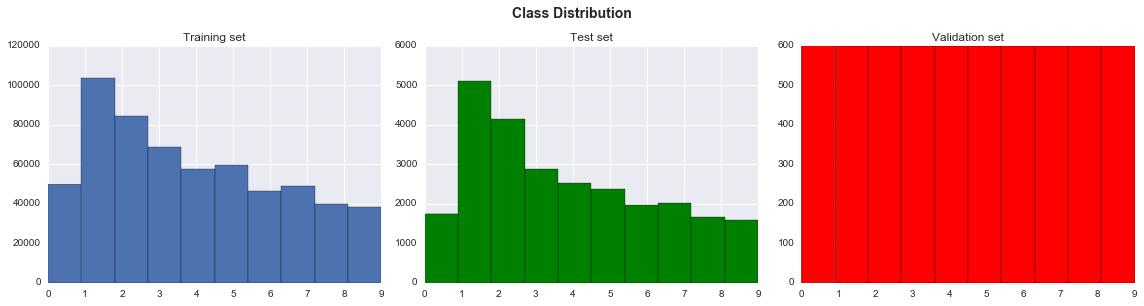

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(0, 9)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

ax3.hist(y_val, color='r', bins=10);
ax3.set_title("Validation set");

fig.tight_layout()

Having a different distribution on the validation set means that validate the models ability to recognize digits where each number is equally important.

Let´s perform a **sanity check** on our dataset to make sure everything is still in order. First, check that we have the same number of images as we initially had, then visualize our digits to see that the labels and images still match.

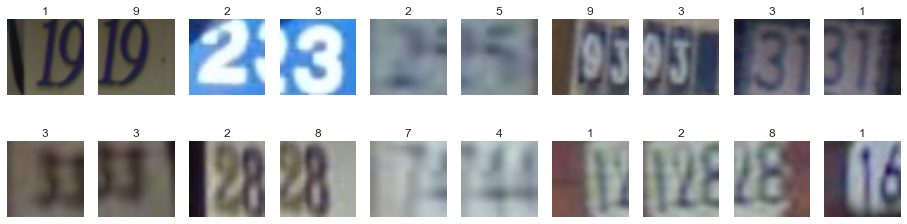

In [14]:
# Assert that we did not remove or add any duplicates
assert(num_images == X_train.shape[0] + X_test.shape[0] + X_val.shape[0])

# Display some samples images from the training set
plot_images(X_train, y_train, 2, 10)

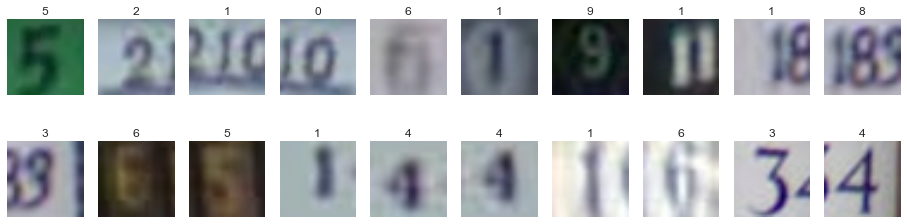

In [15]:
# Display some samples images from the test set
plot_images(X_test, y_test, 2, 10)

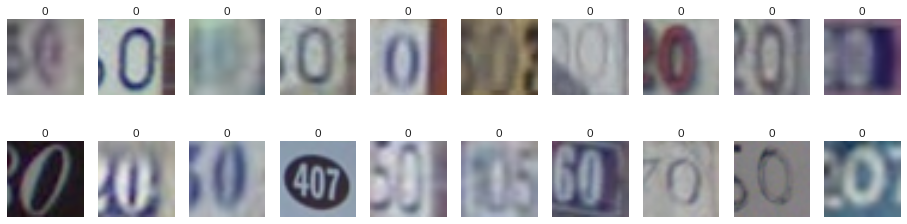

In [16]:
# Display some samples images from the validation set
plot_images(X_val, y_val, 2, 10)

### RGB to Grayscale

To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process. To convert RBG values to grayscale we can take a weighted sum of the R, G, and B components. For more information see [``Converting color to grayscale``](https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale).

$ Y' = 0.2989R + 0.5870G + 0.1140B $

Here is a simple function that helps us print the size of a numpy array in a human readable format.

In [17]:
suffixes = ['B', 'KB', 'MB', 'GB']

def humansize(nbytes):
    if nbytes == 0: return '0 B'
    i = 0
    while nbytes >= 1024:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

Let's convert our digits to grayscale and compare the total size of the arrays before and after the transformation and display a few samples of our transformed images. We add an additional dimension to our greyscale images to make it easier to write ``TensorFlow`` codes that work on both color and greyscale images.

Dimensions
('Training set', (598388, 32, 32, 3), (598388, 32, 32, 1))
('Test set', (26032, 32, 32, 3), (26032, 32, 32, 1))
('Validation set', (6000, 32, 32, 3), (6000, 32, 32, 1))

Data Type
('Training set', dtype('uint8'), dtype('float32'))
('Test set', dtype('uint8'), dtype('float32'))
('Validation set', dtype('uint8'), dtype('float32'))

Dataset Size
('Training set', '1.71 GB', '2.28 GB')
('Test set', '76.27 MB', '101.69 MB')
('Validation set', '17.58 MB', '23.44 MB')


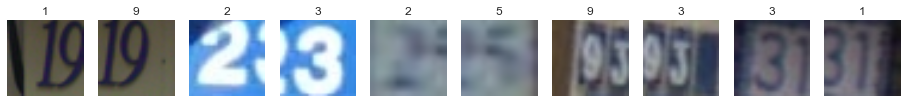

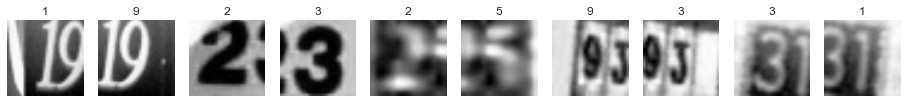

In [18]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    return np.expand_dims(np.dot(images, [0.2989, 0.5870, 0.1140]), axis=3)

# Transform the images to greyscale
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
valid_greyscale = rgb2gray(X_val).astype(np.float32)

# Keep the size before convertion
size_before = (X_train.nbytes, X_test.nbytes, X_val.nbytes)

# Size after transformation
size_after = (train_greyscale.nbytes, test_greyscale.nbytes, valid_greyscale.nbytes)

print("Dimensions")
print("Training set", X_train.shape, train_greyscale.shape)
print("Test set", X_test.shape, test_greyscale.shape)
print("Validation set", X_val.shape, valid_greyscale.shape)
print('')

print("Data Type")
print("Training set", X_train.dtype, train_greyscale.dtype)
print("Test set", X_test.dtype, test_greyscale.dtype)
print("Validation set", X_val.dtype, valid_greyscale.dtype)
print('')

print("Dataset Size")
print("Training set", humansize(size_before[0]), humansize(size_after[0]))
print("Test set", humansize(size_before[1]), humansize(size_after[1]))
print("Validation set", humansize(size_before[2]), humansize(size_after[2]))

plot_images(X_train, y_train, 1, 10)
plot_images(train_greyscale, y_train, 1, 10)

Even though we cut the total number of elements in the array in 3 the new array takes up more space since we use a different and more expensive datatype.

### One Hot Encoding

Finally we apply One Hot Encoding to our label values.

In [19]:
from sklearn.preprocessing import OneHotEncoder
 
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Test set", y_test.shape)
print("Training set", y_val.shape)

('Training set', (598388,))
('Test set', (26032,))
('Training set', (6000,))

('Training set', (598388, 10))
('Test set', (26032, 10))
('Training set', (6000, 10))


## Storing the Changes

Let's store our new datasets in a pickle file that can be used as model input. Since i was experiencing some issues with pickle i decided to give [``h5py``](http://docs.h5py.org/en/latest/quick.html) a shot. For the sake of experimentation we store both the RGB and greyscale images.

Let's start by storing the **RGB images**.

In [25]:
import h5py

# Create file
h5f = h5py.File('data/SVHN_single.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('y_train', data=train_labels)
h5f.create_dataset('X_test', data=X_test)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=X_val)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

... and the **greyscale** images.

In [26]:
import h5py

# Create file
h5f = h5py.File('data/SVHN_single_grey.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=train_greyscale)
h5f.create_dataset('y_train', data=train_labels)
h5f.create_dataset('X_test', data=test_greyscale)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=valid_greyscale)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

Let's shutdown the notebook using ``Close and Halt`` and implement a model on our new dataset.